In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction import DictVectorizer
import joblib

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgb
import xgboost as xgb

In [2]:
df = pd.read_csv("data/Clean_Dataset.csv",index_col=0)

In [3]:
df.head()

,airline,flight,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left,price
0,SpiceJet,SG-8709,Delhi,Evening,zero,Night,Mumbai,Economy,2.17,1,5953
1,SpiceJet,SG-8157,Delhi,Early_Morning,zero,Morning,Mumbai,Economy,2.33,1,5953
2,AirAsia,I5-764,Delhi,Early_Morning,zero,Early_Morning,Mumbai,Economy,2.17,1,5956
3,Vistara,UK-995,Delhi,Morning,zero,Afternoon,Mumbai,Economy,2.25,1,5955
4,Vistara,UK-963,Delhi,Morning,zero,Morning,Mumbai,Economy,2.33,1,5955


In [4]:
df.shape

(300153, 11)

In [4]:
df_train_full, df_test = train_test_split(df, test_size=0.2,random_state=42)
df_train, df_val = train_test_split(df_train_full, test_size=0.25,random_state=42)

In [5]:
df_train.isnull().sum()

airline             0
flight              0
source_city         0
departure_time      0
stops               0
arrival_time        0
destination_city    0
class               0
duration            0
days_left           0
price               0
dtype: int64

- No column has null.

In [6]:
def plot_counter_plot(data,column):
    data = data.groupby([column])[column].count()
    
    data1 = pd.DataFrame()
    data1[column] = data.index
    data1["count"] = data.values
    
    data1.sort_values(by=["count"], inplace = True,ascending=False)
    
    ax = sns.barplot(x=data1[column], y=data1["count"])
    for i in ax.containers:
        ax.bar_label(i,)

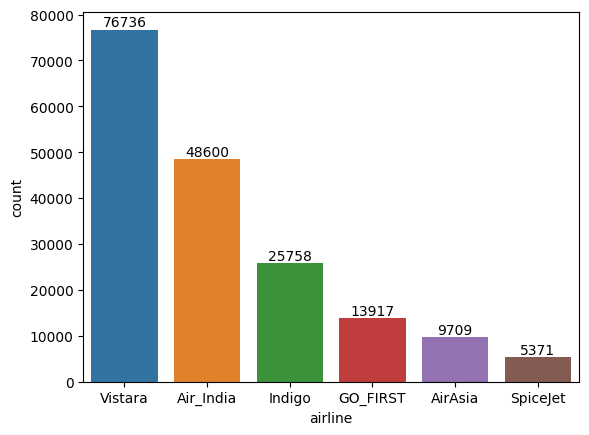

In [7]:
plot_counter_plot(df_train,"airline")

- Most travelled airlines in india are 
    1. `Vistara = 76542` 
    
    2. `Air India = 48635`
    
    3. `Indigo = 25885`
    
    4. `Go First = 13853`
    
    5. `Air Asia = 9747`
    
    6. `Spice Jet = 5429`

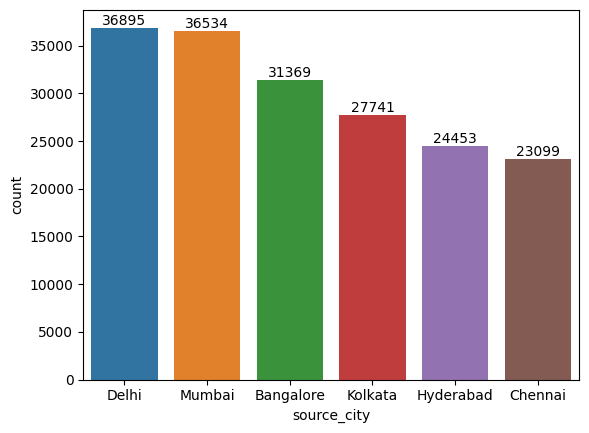

In [8]:
plot_counter_plot(df_train, "source_city")

- Cities from where most aeroplane take off (Source city)
    1. `Delhi = 36890` 
    
    2. `Mumbai = 36470`
    
    3. `Banglore = 31355`
    
    4. `Kolkata = 27822`
    
    5. `Hyderabad = 24479`
    
    6. `Chennai = 23075`

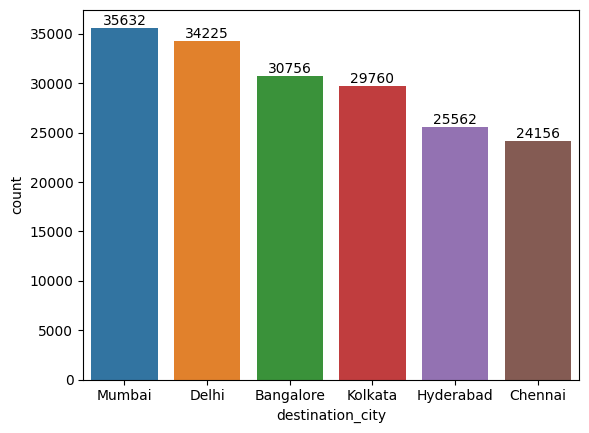

In [9]:
plot_counter_plot(df_train, "destination_city")

- Cities where most aeroplane landed (Destination city).
    2. `Mumbai = 35606`
    
    1. `Delhi = 34419` 
    
    3. `Banglore = 30609`
    
    4. `Kolkata = 29786`
    
    5. `Hyderabad = 25474`
    
    6. `Chennai = 24197`

In [10]:
df_train["source_destination"] = df_train["source_city"] +"_"+ df_train["destination_city"]

In [11]:
def get_count_result(data,column):
    data = data.groupby([column])[column].count()
    
    data1 = pd.DataFrame()
    data1[column] = data.index
    data1["count"] = data.values
    
    data1.sort_values(by=["count"], inplace = True,ascending=False)
    return data1.reset_index(drop=True)

In [12]:
data = get_count_result(df_train,column="source_destination")
data.head(5)

,source_destination,count
0,Delhi_Mumbai,9163
1,Mumbai_Delhi,8894
2,Delhi_Bangalore,8525
3,Bangalore_Delhi,8252
4,Bangalore_Mumbai,7782


- Top 5 india cities which has highest connectivity through airways are.
    |__FROM__|__TO__|count|
    |:------:|:---:|:---:|
    |Dehi|Mumbai|9236|
    |Mumbai|Delhi|8907|
    |Delhi|Bangalore|8427|
    |Bangalore|Delhi|8297|
    |Bangalore|Mumbai|7866|
    

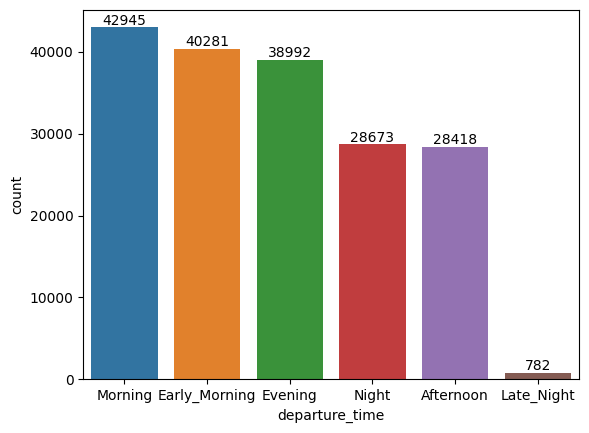

In [13]:
plot_counter_plot(df_train,"departure_time")

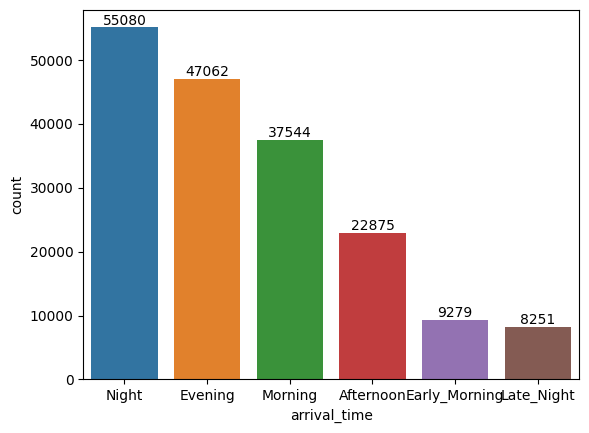

In [14]:
plot_counter_plot(df_train,"arrival_time")

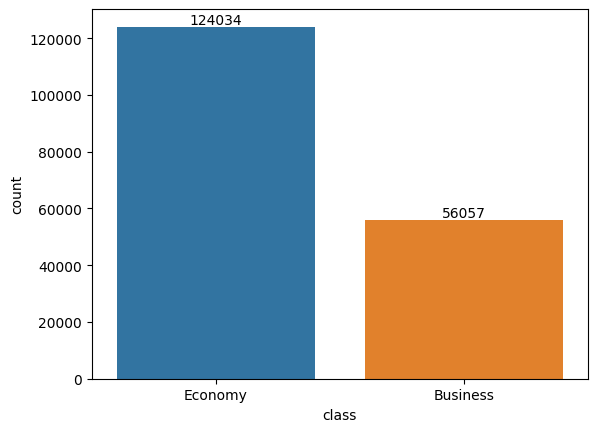

In [15]:
plot_counter_plot(df_train,"class")

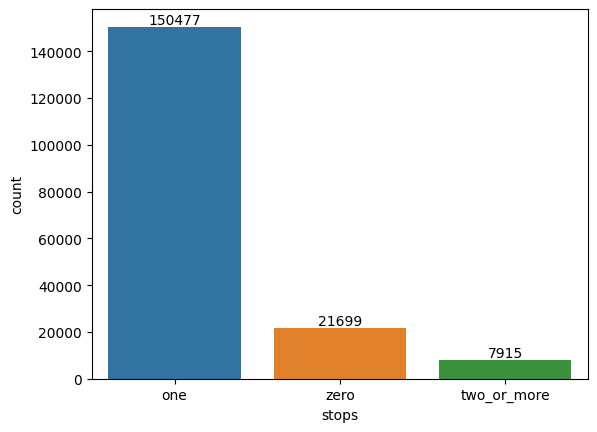

In [16]:
plot_counter_plot(df_train,"stops")

In [17]:
mu = round(df_train['price'].mean(),2)
print("Mean Price of the ticket is: ", mu)

Mean Price of the ticket is:  20868.05


In [18]:
def plot_distplot(data,column,hue=None,log=False):
    sns.displot(data, x=column, kind="kde",hue=hue,log_scale=log)

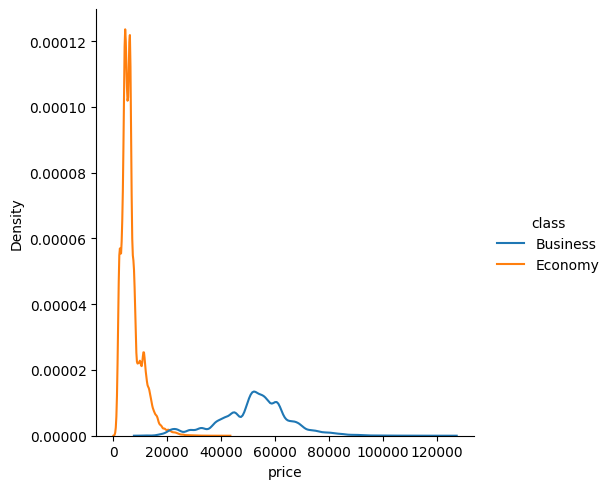

In [19]:
plot_distplot(df_train,"price",hue = "class")

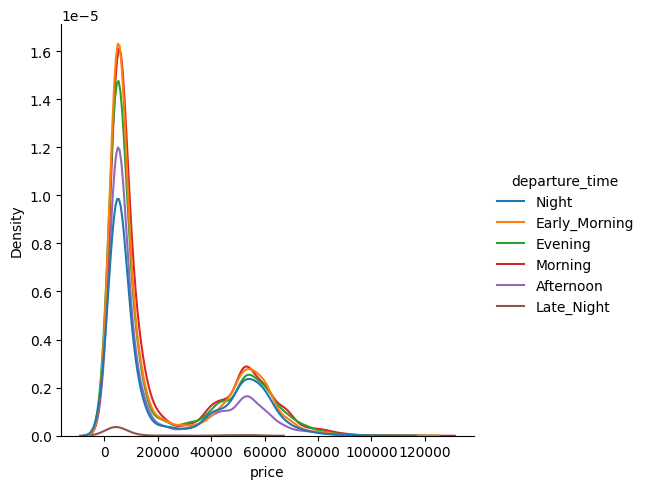

In [20]:
plot_distplot(df_train,"price",hue = "departure_time")

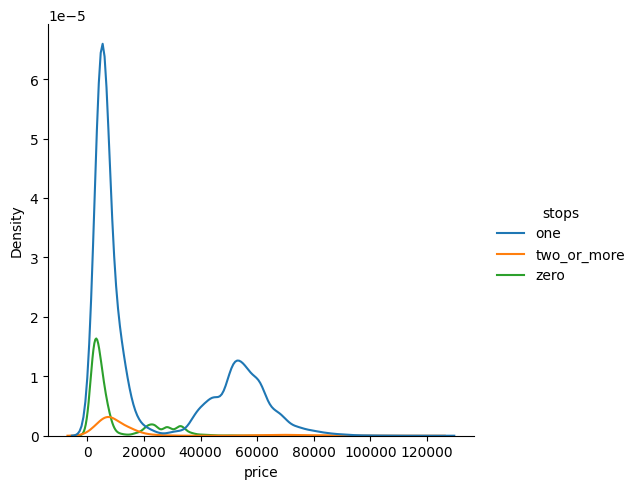

In [21]:
plot_distplot(df_train,"price",hue = "stops")

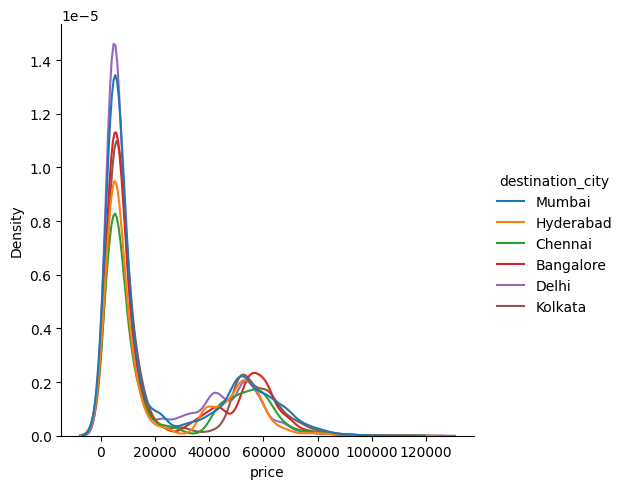

In [22]:
plot_distplot(df_train,"price",hue = "destination_city")

### Modeling

In [23]:
X_col = ['airline', 'source_city', 'departure_time','stops',
       'arrival_time', 'destination_city', 'class','days_left']

y_col = 'price'

In [24]:
X_train = df_train[X_col]
y_train = df_train[y_col]

X_val  = df_val[X_col]
y_val  = df_val[y_col]

X_test = df_test[X_col]
y_test = df_test[y_col]

In [25]:
X_train_dict = X_train.to_dict(orient='records')
X_val_dict   = X_val.to_dict(orient='records')
X_test_dict  = X_test.to_dict(orient='records')


dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(X_train_dict)
X_val   = dv.transform(X_val_dict)
X_test  = dv.transform(X_test_dict)

columns = dv.feature_names_

In [26]:
def get_model_result(models,X_train,y_train,X_val,y_val):
    for i in range(len(models)):
        model = models[i]
        print("training_model... ", model)
        model.fit(X_train,y_train)
        y_train_pred = model.predict(X_train)
        y_val_pred   = model.predict(X_val)
        val_rmse   = round(mean_squared_error(y_val, y_val_pred)**.5,2)
        print("\tval_rmse  :", val_rmse)
        print()

In [27]:
models = [LinearRegression(),RandomForestRegressor(),lgb.LGBMRegressor(),xgb.XGBRegressor()]

In [28]:
modeling_result = get_model_result(models,X_train,y_train,X_val,y_val)

training_model...  LinearRegression()
	val_rmse  : 6754.81

training_model...  RandomForestRegressor()
	val_rmse  : 4412.04

training_model...  LGBMRegressor()
	val_rmse  : 4222.74

training_model...  XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...)
	val_rmse  : 4003.54



In [29]:
def get_xgb_model_result(params,X_train,y_train):
    xgbr = xgb.XGBRegressor(seed = 20)
    model = RandomizedSearchCV(estimator=xgbr,
                         param_distributions=params,
                         scoring='neg_mean_squared_error',
                         n_iter=25,
                         verbose=1)
    model.fit(X_train,y_train)
    return model

In [30]:
params = { 'max_depth': [3, 5, 6, 10],
           'learning_rate': [0.01, 0.1, 0.2, 0.3],
           'subsample': np.arange(0.4, 1.0, 0.2),
           'colsample_bytree': np.arange(0.4, 1.0, 0.2),
           'colsample_bylevel': np.arange(0.4, 1.0, 0.2),
           'n_estimators': [100, 500, 1000],
           'n_jobs':[-1]}

model = get_xgb_model_result(params,X_train,y_train)

Fitting 5 folds for each of 25 candidates, totalling 125 fits


In [31]:
model.best_params_

{'subsample': 0.8000000000000002,
 'n_jobs': -1,
 'n_estimators': 100,
 'max_depth': 10,
 'learning_rate': 0.2,
 'colsample_bytree': 0.6000000000000001,
 'colsample_bylevel': 0.4}

In [32]:
model.best_estimator_

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=0.4, colsample_bynode=1,
             colsample_bytree=0.6000000000000001, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=0, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.2, max_bin=256,
             max_cat_to_onehot=4, max_delta_step=0, max_depth=10, max_leaves=0,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=-1, num_parallel_tree=1, predictor='auto',
             random_state=20, reg_alpha=0, reg_lambda=1, ...)